<a href="https://colab.research.google.com/github/smpark0520/ESAA/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EA%B5%90%EA%B3%BC%EC%84%9C_ch5_3_p_200~229.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.3 전이 학습

* 전이 학습은 **데이터가 적은 현실적인 상황**에서 매우 유용함
* 사전 훈련된 모델을 활용하여 **효율적 학습 가능**
* 대표적인 기법:

  * 특성 추출 (Feature Extraction)
  * 미세 조정 (Fine-tuning)

## 5.3.1 특성 추출 기법

> **특성 추출** : 전이 학습에서 사전 훈련된 모델의 합성곱층을 그대로 사용하고, 마지막 완전연결층만 새로 학습하는 방법

* 마지막 완전연결층: 이미지의 카테고리를 결정하는 부분
* 합성곱층의 가중치는 고정하고, 완전연결층만 학습



### 구조

**이미지 분류 모델 = 합성곱층 + 데이터 분류기**

1. **합성곱층 (Convolutional Layers)**

   * 합성곱층 + 풀링층 (특성 추출 역할)
   * 사전 훈련된 네트워크에서 가져오고 **학습되지 않음** (가중치 고정)

2. **데이터 분류기 (Fully Connected Layers)**

   * 추출된 특성을 입력받아 **최종 클래스를 분류**
   * **새로 구성**하고 **훈련 대상이 됨**

---

특성 추출에 사용되는 주요 모델

* **Xception**
* **Inception V3**
* **ResNet50**
* **VGG16**
* **VGG19**
* **MobileNet**


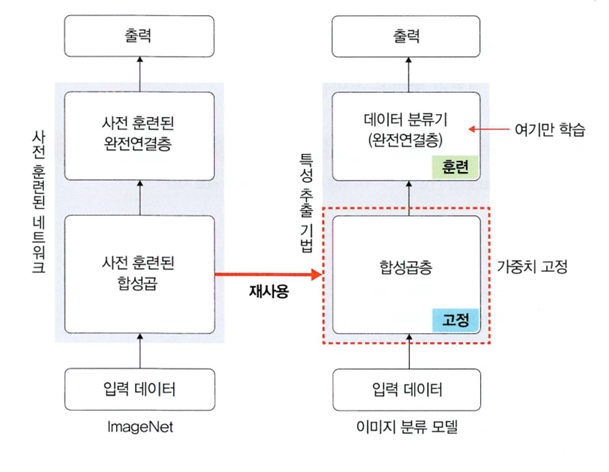

In [2]:
 pip install opencv-python

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 라이브러리 호출

In [4]:
import os
import time
import copy
import glob
import cv2 # OpenCV 라이브러리
import shutil
import torch
import torchvision # 컴퓨터 비전용 패키지
import torchvision.transforms as transforms  # 데이터 전처리용
import torchvision.models as models # 다양한 파이토치 네트워크
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

- 이미지 데이터 전처리 방법 정의

In [5]:
data_path = '/content/drive/MyDrive/25-1 ESAA OB/catanddog/train'  # 이미지 데이터 경로 지정

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


- transforms.Resize([256, 256])

→ 이미지를 256×256 크기로 고정 조정

→ 주로 합성곱층 입력 크기를 맞추기 위한 전처리용

- transforms.RandomResizedCrop(224)

→ 이미지를 랜덤한 비율로 자른 후, 224×224 크기로 재조정

→ 데이터 증강(data augmentation) 목적

- transforms.RandomHorizontalFlip()

→ 이미지를 랜덤하게 수평으로 뒤집음

→ 역시 데이터 증강 기법

- transforms.ToTensor()

→ 이미지 데이터를 Tensor 형식으로 변환 (모델에 입력 가능하게 함)

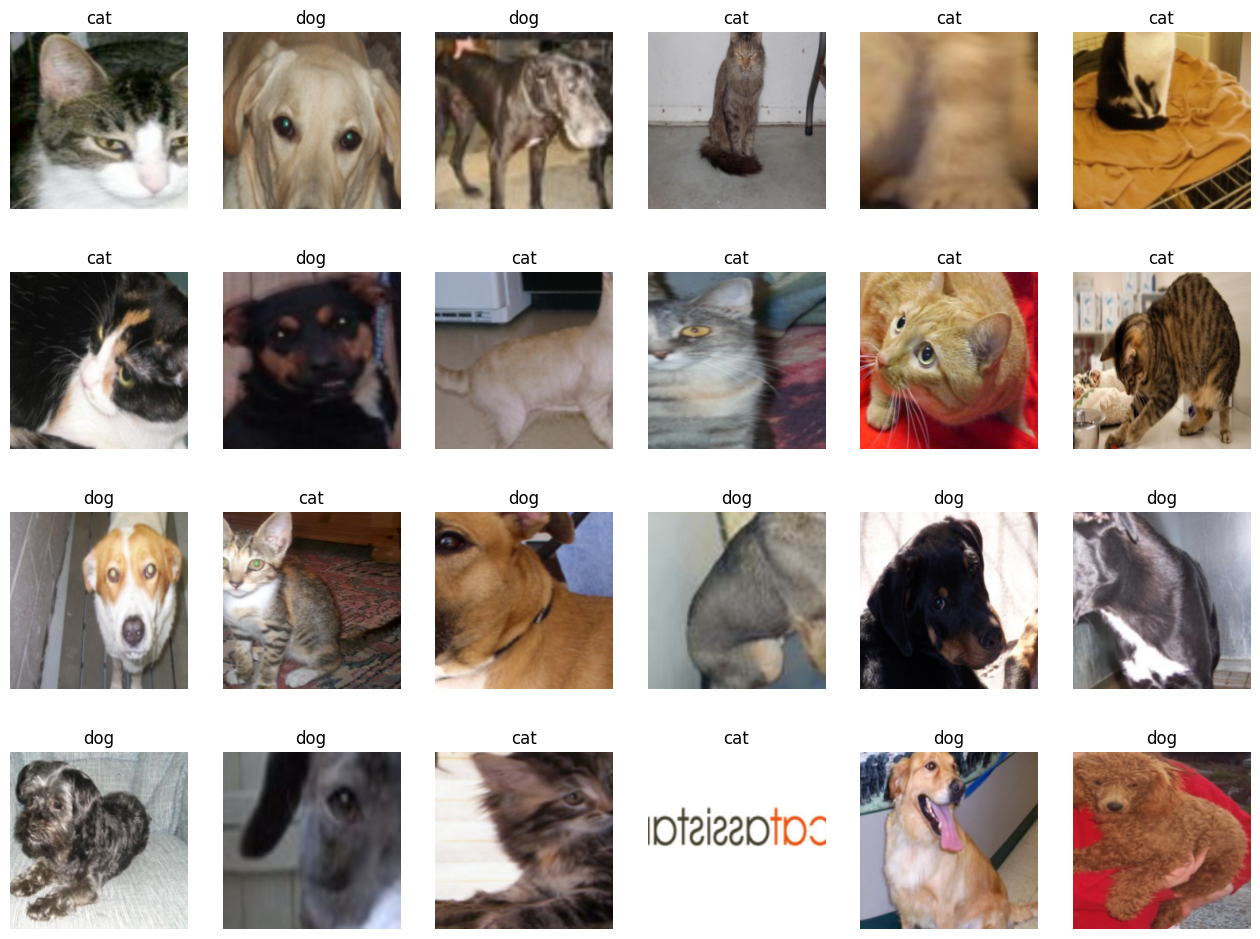

In [6]:
# 학습에 사용될 이미지 출력
import numpy as np

samples, labels = next(iter(train_loader)) # 반복자와 같은 효과.
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize = (16,24))
for i in range(24):
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off') #
  a.imshow(np.transpose(samples[i].numpy(),(1,2,0))) # np.transpose: 행렬 전치. torch.Size([3, 224, 224]) -> (244,244,3)
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

* `train_loader`에서 하나의 배치를 추출하여 이미지(`samples`)와 레이블(`labels`)을 가져옴
* `classes = \{0: \text{'cat'},\ 1: \text{'dog'}\}`처럼 숫자 레이블을 문자열 클래스로 매핑
* `plt.figure(figsize=(16, 24))`는 전체 출력 이미지의 크기를 설정
* 반복문을 통해 총 24장의 이미지를 4x6 배열로 시각화
* 각 subplot에는 해당 이미지의 클래스명을 제목으로 설정하고, 축 눈금은 표시하지 않음
* PyTorch의 이미지 텐서 형식은 $(C, H, W)$이므로, 이를 Matplotlib이 요구하는 $(H, W, C)$ 형식으로 전치(transpose)
* `plt.subplots_adjust`는 subplot 사이의 간격 및 여백을 조정하여 보기 좋은 배치를 만듦


- 사전 훈련된 ResNet18 모델 내려받기

In [7]:
resnet18 = models.resnet18(pretrained=True) # pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


- 사전 훈련된 모델의 파라미터 학습 유무 지정

In [8]:
def set_parameter_requires_grad(model, featre_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad

<function __main__.set_parameter_requires_grad(model, featre_extracting=True)>

- ResNet18에 완전연결층 추가

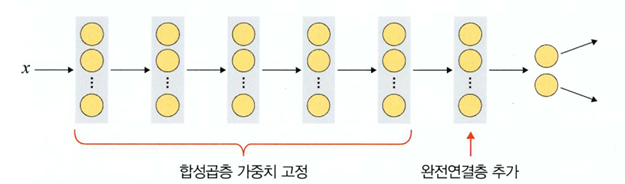

In [9]:
resnet18.fc = nn.Linear(512, 2) # 2는 클래스가 두 개라는 의미

- 모델의 파라미터 값 확인

In [10]:
for name, param in resnet18.named_parameters(): # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
  if param.requires_grad:
    print(name, param.data)

conv1.weight tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04, -2.5743e-02],
          [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01,
           -1.6051e-01, -1.2826e-03],
          [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,
            3.6887e-01,  1.2455e-01],
       

- 모델 객체 생성 및 손실 함수 정의

In [11]:
model = models.resnet18(pretrained=True) # 모델의 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 조정
  param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): # 완전연결층은 학습
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실함수 정의
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 모델 학습을 위한 함수 생성

In [12]:
import time
import torch
import os

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()  # 현재 시간 저장 (학습 시간 측정용)

    acc_history = []
    loss_history = []

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            optimizer.zero_grad()  # 기울기 초기화

            outputs = model(inputs)  # 순전파
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)  # 예측값 계산

            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트

            running_loss += loss.item() * inputs.size(0)  # 누적 손실
            running_corrects += torch.sum(preds == labels.data)  # 누적 정확도

        epoch_loss = running_loss / len(dataloaders.dataset)  # 평균 손실
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 평균 정확도

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        # 모델 저장
        torch.save(model.state_dict(), os.path.join(
            '/content/drive/MyDrive/25-1 ESAA OB/catanddog/', '{0:0=2d}.pth'.format(epoch)))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history, loss_history

- 파라미터 학습 결과를 옵티마이저에 전달

In [13]:
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t", name)

optimizer = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

- 모델 학습

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loss: 0.6294 Acc: 0.7403

Epoch 1/12
----------
Loss: 0.6032 Acc: 0.7273

Epoch 2/12
----------
Loss: 0.4362 Acc: 0.7610

Epoch 3/12
----------
Loss: 0.3974 Acc: 0.7974

Epoch 4/12
----------
Loss: 0.3405 Acc: 0.8286

Epoch 5/12
----------
Loss: 0.3319 Acc: 0.8312

Epoch 6/12
----------
Loss: 0.2743 Acc: 0.8727

Epoch 7/12
----------
Loss: 0.3294 Acc: 0.8286

Epoch 8/12
----------
Loss: 0.3371 Acc: 0.8519

Epoch 9/12
----------
Loss: 0.3381 Acc: 0.8442

Epoch 10/12
----------
Loss: 0.2794 Acc: 0.8753

Epoch 11/12
----------
Loss: 0.3184 Acc: 0.8519

Epoch 12/12
----------
Loss: 0.3149 Acc: 0.8494

Training complete in 25m 46s
Best Acc: 0.875325


- 테스트 데이터 호출 및 전처리

In [16]:
test_path = '/content/drive/MyDrive/25-1 ESAA OB/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


- 테스트 데이터 평가 함수 생성

In [17]:
import time
import torch
import glob

def eval_model(model, dataloader, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    # .pth 파일 불러오기 및 정렬
    saved_models = glob.glob('/content/drive/MyDrive/25-1 ESAA OB/catanddog/*.pth')
    saved_models.sort()
    print('Saved models:', saved_models)

    for model_path in saved_models:
        print('Loading model:', model_path)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        model.to(device)

        running_corrects = 0

        # 데이터로더에서 배치 단위로 평가
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # gradient 계산 비활성화
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)  # 클래스 예측

            running_corrects += torch.sum(preds == labels.data)

        # 정확도 계산
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        # 최고 정확도 저장
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history

- 테스트 데이터를 평가 함수에 적용

In [18]:
val_acc_hist = eval_model(resnet18, test_loader, device)

Saved models: ['/content/drive/MyDrive/25-1 ESAA OB/catanddog/00.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/01.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/02.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/03.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/04.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/05.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/06.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/07.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/08.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/09.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/10.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/11.pth', '/content/drive/MyDrive/25-1 ESAA OB/catanddog/12.pth']
Loading model: /content/drive/MyDrive/25-1 ESAA OB/catanddog/00.pth
Acc: 0.8265

Loading model: /content/drive/MyDrive/25-1 ESAA OB/catanddog/01.pth
Acc: 0.7959

Loading model: /content/drive/MyDrive/25-1 ESAA OB/catanddog/02.pth
Acc: 0.8163

Loading model:

- 훈련과 테스트 데이터의 정확도를 그래프로 확인

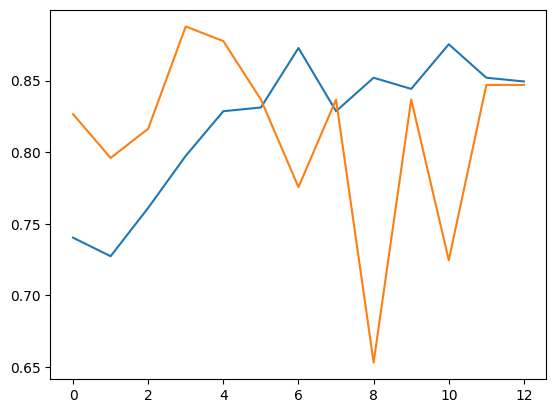

In [19]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

- 훈련 데이터의 오차어| 대한 그래프 확인

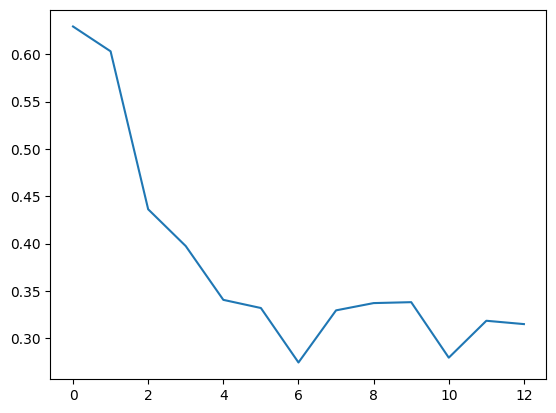

In [20]:
plt.plot(train_loss_hist)
plt.show()

- 예측 이미지 출력을 위한 전처리 함수

In [21]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
  image = image.clip(0, 1)
  return image

- 개와 고양이 예측 결과 출력

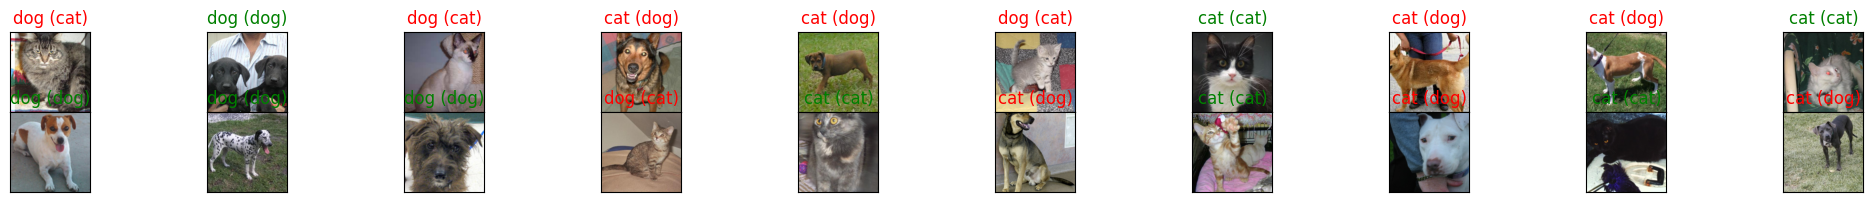

In [22]:
# 클래스 딕셔너리
classes = {0: 'cat', 1: 'dog'}

# 테스트 데이터 로더에서 하나의 배치 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 모델을 평가 모드로 전환
model.eval()

# 모델 예측
images = images.to(device)
with torch.no_grad():
    output = model(images)
    _, preds = torch.max(output, 1)

# 결과 시각화 (20개)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(im_convert(images[idx].cpu()))  # 이미지 복원 함수 적용 (CPU로 이동 필요)

    # 정답과 예측 라벨 비교하여 색상 지정
    color = "green" if preds[idx] == labels[idx].to(device) else "red"
    ax.set_title("{} ({})".format(classes[preds[idx].item()], classes[labels[idx].item()]), color=color)

# 레이아웃 조정 및 출력
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
plt.show()

## 5.3.2 미세 조정 기법

: 사전 훈련된 모델의 가중치를 전체 또는 일부 업데이트하여 새로운 데이터셋에 맞게 성능을 향상시키는 기법

| 데이터셋 크기 | 사전 모델과 유사성 | 전략                         |
| ------- | ---------- | -------------------------- |
| 크다  | 작다    | 전체 모델을 재학습                 |
| 크다  | 크다     | 뒷부분 합성곱층 + 분류기만 학습     |
| 작다 | 작다     | 일부 합성곱층 + 분류기만 학습      |
| 작다  | 크다     | 데이터 분류기(완전연결층)만 학습 |


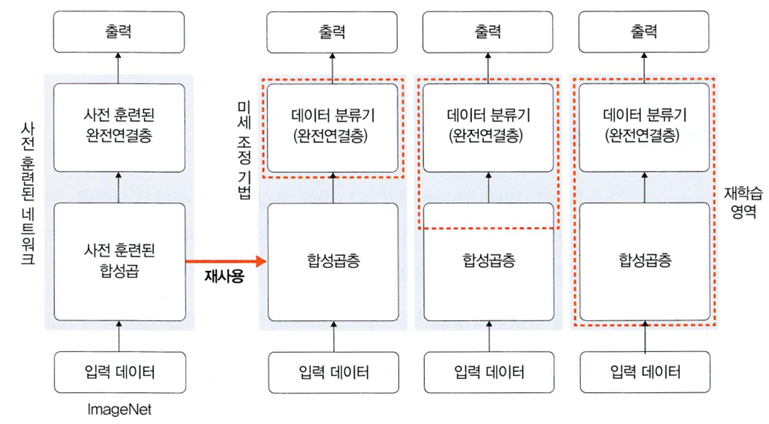